In [2]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt

import mne

from corrts import *

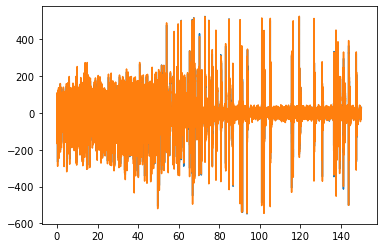

In [5]:
fname = 'data_csd_rodent.csv'
data  = np.loadtxt(fname, delimiter=',')

if fname == 'data_ve.csv':
    sname = ['rOFA', 'lFFA']
    nsrc  = 2
    ntime = 161
    ntri  = 336
    sfreq = 200
    
elif fname == 'data_csd_rodent.csv': 
    sname = ['A1', 'A2']
    nsrc  = 2
    ntime = 30000
    ntri  = 4
    sfreq = 125
    
dims = (nsrc, ntri, ntime)
tvec = np.arange(ntime) / 200.
    
    
data = data.reshape(dims)

# put data in mne format, i.e. (trials, channels, time)
data = np.transpose(data, axes=[1,0,2])


plt.plot(tvec, data[0,:,:].T); 

In [6]:
freq = np.linspace(1,60,32) 
rg   = 100
Nc   = np.maximum(1, np.round(np.sqrt(2 * (np.pi * freq)**2 / rg)))
print(Nc)

tfr  = mne.time_frequency.tfr_array_morlet(data, sfreq, freq, n_cycles=Nc, output='power')
tfr  = np.sqrt(tfr)

[ 1.  1.  2.  3.  4.  5.  6.  6.  7.  8.  9. 10. 11. 11. 12. 13. 14. 15.
 16. 17. 17. 18. 19. 20. 21. 22. 22. 23. 24. 25. 26. 27.]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


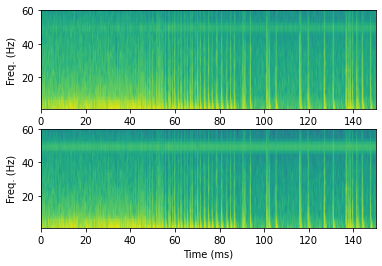

In [7]:
def plot_tfr(tfr, tvec, freq):
    extent = (tvec[0], tvec[-1], freq[0], freq[-1])
    
    plt.subplot(2,1,1)
    plt.imshow(tfr[0], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.subplot(2,1,2)
    plt.imshow(tfr[1], aspect="auto", origin="lower", extent=extent)
    plt.xlabel('Time (ms)')
    plt.ylabel('Freq. (Hz)')
    
    plt.show()
    
plot_tfr(np.log(tfr[0]), tvec, freq)

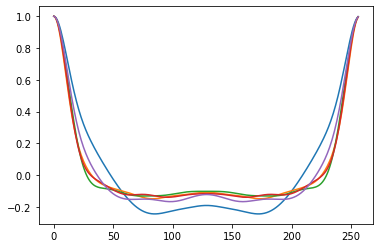

In [8]:
fbands = dict(
    delta = (freq[0], 4), 
    theta = (4, 8), 
    alpha = (8, 13),
    beta  = (13, 30), 
    gamma = (30, freq[-1])
)

idxs = {k: np.where(np.logical_and(freq >= fmin, freq < fmax))[0]
       for k, (fmin, fmax) in fbands.items()}

pband = {k: tfr[:,:,idx].sum(2) for k, idx in idxs.items()} 
acfs  = {k: acf_welch(p) for k, p in pband.items()} 

for k, acf in acfs.items(): 
    plt.plot(acf[0,0])

In [32]:
pearson_stats  = {k: stats_summary(pearson_r,  p[:, 0], p[:, 1], n_surrogates=1000) for k, p in pband.items()}
spearman_stats = {k: stats_summary(spearman_r, p[:, 0], p[:, 1], n_surrogates=1000) for k, p in pband.items()}

In [33]:
pearson_stats

{'delta': {'r': array([0.99847347, 0.99622997, 0.99484768, 0.99268304]),
  'z': array([3.58857211, 3.13596582, 2.97943805, 2.80352106]),
  'n': 30000,
  'p': {'uncorrected': array([0., 0., 0., 0.]),
   'rft': array([0., 0., 0., 0.]),
   'bh': array([3.10911704e-102, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]),
   'quenouille': array([8.07031073e-50, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
   'bartlett': array([2.16629737e-97, 4.28732827e-78, 8.16482197e-97, 1.17995267e-68]),
   'surrogates': array([0., 0., 0., 0.])},
  'aedfs': {'rft': array([0.02793392, 0.02859732, 0.03321312, 0.02984322]),
   'bh': array([0.00129293, 0.0072718 , 0.00938163, 0.01400975]),
   'quenouille': array([0.00067004, 0.00552103, 0.0071744 , 0.01033455]),
   'bartlett': array([0.00123532, 0.00128625, 0.00173706, 0.00140046])},
  'nedfs': {'rft': array([838.01755915, 857.91968384, 996.39374034, 895.29667777]),
   'bh': array([ 38.78778091, 218.15412071, 281.44877001, 420.29241045]),
   'quenouil